<a href="https://colab.research.google.com/github/GOUTAM-RAM21/data-science-ml/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: goutamsinghrajput
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:08<00:00, 89.6MB/s]

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available:", device)

Device available: cuda


In [3]:
image_path = []
labels = []

BASE_DIR = "/content/animal-faces/afhq"

for i in os.listdir(BASE_DIR):
    for label in os.listdir(f"{BASE_DIR}/{i}"):
        for image in os.listdir(f"{BASE_DIR}/{i}/{label}"):
            full_path = f"{BASE_DIR}/{i}/{label}/{image}"
            image_path.append(full_path)
            labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(data_df["labels"].unique())
data_df.head()

['cat' 'dog' 'wild']


,image_path,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [4]:
train = data_df.sample(frac=0.7, random_state=42)
test_val = data_df.drop(train.index)

val = test_val.sample(frac=0.5, random_state=42)
test = test_val.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [7]:
Label_encoder = LabelEncoder()
Label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(Label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [11]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [14]:
train_dataset.__getitem__(2)

(tensor([[[0.6627, 0.6627, 0.6627,  ..., 0.7098, 0.7020, 0.6980],
          [0.6706, 0.6706, 0.6745,  ..., 0.7020, 0.6980, 0.6941],
          [0.6863, 0.6863, 0.6824,  ..., 0.6902, 0.6902, 0.6863],
          ...,
          [0.4706, 0.4627, 0.4471,  ..., 0.4196, 0.4235, 0.3843],
          [0.4588, 0.4510, 0.4078,  ..., 0.4588, 0.4745, 0.4510],
          [0.4275, 0.4039, 0.3765,  ..., 0.4588, 0.4627, 0.4471]],
 
         [[0.6863, 0.6824, 0.6824,  ..., 0.6627, 0.6549, 0.6510],
          [0.6941, 0.6941, 0.6941,  ..., 0.6549, 0.6510, 0.6471],
          [0.7098, 0.7098, 0.7059,  ..., 0.6431, 0.6431, 0.6392],
          ...,
          [0.5176, 0.5137, 0.5059,  ..., 0.3020, 0.3059, 0.2588],
          [0.5412, 0.5373, 0.5020,  ..., 0.3333, 0.3490, 0.3176],
          [0.5333, 0.5176, 0.4980,  ..., 0.3255, 0.3294, 0.3059]],
 
         [[0.6863, 0.6941, 0.6980,  ..., 0.5608, 0.5569, 0.5490],
          [0.6902, 0.6980, 0.7059,  ..., 0.5608, 0.5569, 0.5529],
          [0.6941, 0.7020, 0.7098,  ...,

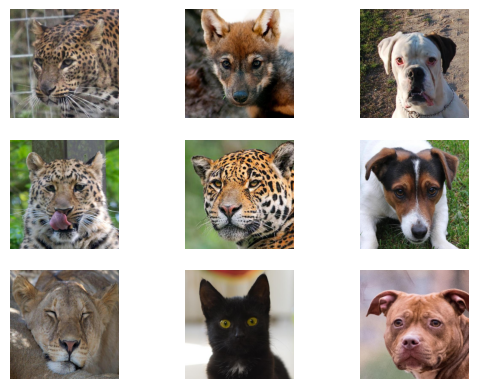

In [19]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.show()

In [20]:

LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding=1)

        self.pooling = nn.MaxPool2d(2,2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.conv1(x) # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [26]:
from torchsummary import summary

model = Net().to(device)
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [28]:
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(
        round((total_acc_train / train_dataset.__len__()) * 100, 4)
    )
    total_acc_validation_plot.append(
        round((total_acc_val / val_dataset.__len__()) * 100, 4)
    )

    print(f'''
Epoch {epoch+1}/{EPOCHS},
Train Loss: {round(total_loss_train/1000, 4)}
Train Accuracy {round((total_acc_train/train_dataset.__len__()) * 100, 4)}
Validation Loss {round(total_loss_val/1000, 4)}
Validation Accuracy {round((total_acc_val/val_dataset.__len__()) * 100, 4)}
''')


Epoch 1/10,
Train Loss: 0.3105
Train Accuracy 82.0565
Validation Loss 0.0403
Validation Accuracy 90.5372


Epoch 2/10,
Train Loss: 0.1366
Train Accuracy 92.8881
Validation Loss 0.0259
Validation Accuracy 93.9669


Epoch 3/10,
Train Loss: 0.0877
Train Accuracy 95.7134
Validation Loss 0.0228
Validation Accuracy 95.124


Epoch 4/10,
Train Loss: 0.0612
Train Accuracy 96.8293
Validation Loss 0.0229
Validation Accuracy 95.124


Epoch 5/10,
Train Loss: 0.0431
Train Accuracy 97.8833
Validation Loss 0.0209
Validation Accuracy 95.6612


Epoch 6/10,
Train Loss: 0.0327
Train Accuracy 98.3881
Validation Loss 0.0201
Validation Accuracy 95.7438


Epoch 7/10,
Train Loss: 0.024
Train Accuracy 98.8221
Validation Loss 0.0227
Validation Accuracy 95.0


Epoch 8/10,
Train Loss: 0.0171
Train Accuracy 99.256
Validation Loss 0.0264
Validation Accuracy 94.9174


Epoch 9/10,
Train Loss: 0.0114
Train Accuracy 99.5217
Validation Loss 0.0266
Validation Accuracy 95.8264


Epoch 10/10,
Train Loss: 0.0158
Train Accur

In [30]:
total_acc_test = 0
total_loss_test = 0 # Initialize total_loss_test

for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += acc

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} "
      f"and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.4035 and Loss is 0.019


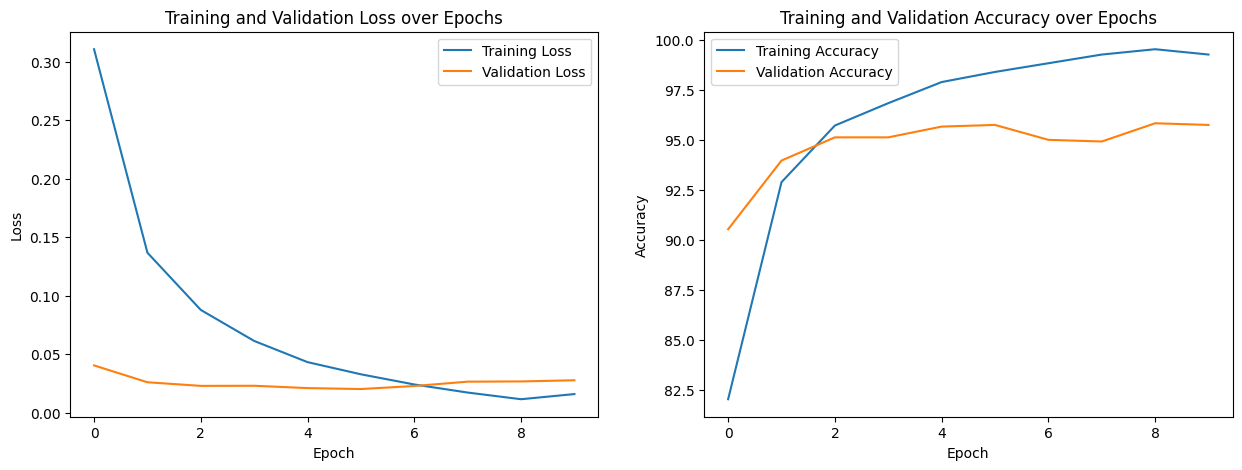

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


In [35]:
# 1 - read image
# 2 - Transform using transform object
# 3 - predict through the model
# 4 - inverse transform by label encoder

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)

    output = model(image.unsqueeze(0))
    print(output)

    output = torch.argmax(output, axis=1).item()
    return Label_encoder.inverse_transform([output])

In [36]:
predict_image(test.iloc[0]['image_path'])

tensor([[ 19.8140, -17.5173,   0.8879]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['cat'], dtype=object)

In [34]:
tensor([...], device='cuda:0')
array(['wild'], dtype=object)


NameError: name 'tensor' is not defined

In [37]:
predict_image(test.iloc[1]['image_path'])

tensor([[ 1.8489, -1.9191,  0.3461]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['cat'], dtype=object)